Fine-tuning the SAM (Segment-Anything-Model) for river water segmentation proves to be a seamless process under the expert modifications by Armin Moghimi. His enhancements enable the model to effortlessly accommodate the original image size, eliminating the need for resizing to 512x512 dimensions. The removal of this constraint empowers the adapted SAM model with heightened flexibility in handling diverse image dimensions, not only optimizing river water segmentation but also extending its capabilities to enhance performance across various segmentation tasks. Armin Moghimi's adept modifications and rewrites of the code, originally authored by **Alexandre Bonnet** and freely available for fine-tuning (https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/), showcase an unparalleled synergy that unlocks greater potential and versatility in segmentation applications beyond the realm of river water.


Moreover, I would like to express my sincere appreciation to **Alexandre Bonnet** and **Piotr Skalski** for their excellent tutorials and blog posts on SAM segmentation. Their work significantly helped me in rewriting and modifying the fine-tuning process.










In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from numpy import zeros
from numpy.random import randint
import torch
import os
import cv2
from statistics import mean
from torch.nn.functional import threshold, normalize
# Data Viz
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

Import segment_anything and its dependency

In [ ]:
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth &> /dev/null

Improt Training data



In [ ]:
image_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Train/Images"
total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*.jpg"))
print(f"Total Number of Images : {total_images}")
lable_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Train/Labels"
total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.png"))
print(f"Total Number of Images : {total_lables}")
train_image_paths = all_image_paths[0:total_images]
train_lable_paths = all_lable_paths[0:total_lables]

Total Number of Images : 657
Total Number of Images : 657


Improt Validation data

In [ ]:
image_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Val/Images"
Val_total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*"))
print(f"Total Number of Images : {Val_total_images}")
lable_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Val/labels"
Val_total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.png"))
print(f"Total Number of Images : {Val_total_lables}")
Val1_image_paths = all_image_paths[0:Val_total_images]
Val1_lable_paths = all_lable_paths[0:Val_total_lables]

Total Number of Images : 202
Total Number of Images : 202


Reading ground_truth_masks for training and Validation

In [ ]:
# Please dont run this line if you would like to use the original size of input images.
desired_size=(512, 512)

In [ ]:
ground_truth_masks = {}
for k in range(0, len(train_image_paths)):
    gt_grayscale = cv2.imread(train_lable_paths[k], cv2.IMREAD_GRAYSCALE)
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masks[k] = (gt_grayscale > 0)

In [ ]:
ground_truth_masksv = {}
for s in range(0, len(Val1_lable_paths)):
    gt_grayscale = cv2.imread(Val1_lable_paths[s], cv2.IMREAD_GRAYSCALE)
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masksv[s] = (gt_grayscale > 0)

Import SAM model

In [ ]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [ ]:
model_type = 'vit_l'
checkpoint = 'sam_vit_l_0b3195.pth'
device = 'cuda:0'

In [ ]:
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = 'cuda:0'

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model.to(device)
sam_model.train();

#mobile_sam

#Step 1: Preprocess the images for training

> Indented block




In [ ]:
from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in range(len(train_image_paths)):  # Fix the loop iteration
    image = cv2.imread(train_image_paths[k])
    if desired_size is not None:
        image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k]['image'] = input_image
    transformed_data[k]['input_size'] = input_size
    transformed_data[k]['original_image_size'] = original_image_size


# Set up the optimizer, and Loss


In [ ]:
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
loss_fn   = torch.nn.BCEWithLogitsLoss()
keys = list(ground_truth_masks.keys())
keys1 = list(ground_truth_masksv.keys())
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define batch size
batch_size = 64
num_epochs = 1

# Fine tuning SAM by Training data

In [ ]:
def train_on_batch(keys, batch_start, batch_end):
    batch_losses = []
    batch_accuracies = []

    for k in keys[batch_start:batch_end]:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

        # No grad here as we don't want to optimize the encoders
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )

        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        binary_mask = (threshold(torch.sigmoid(upscaled_masks), 0.5, 0))
        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
        gt_mask_resized = gt_mask_resized > 0.5
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        # Calculate accuracy for training data
        train_accuracy = calculate_accuracy(binary_mask, gt_binary_mask)
        batch_accuracies.append(train_accuracy)

    return batch_losses, batch_accuracies

def calculate_accuracy(predictions, targets):
    binary_predictions = (predictions > 0.5).float()
    accuracy = (binary_predictions == targets).float().mean()
    return accuracy.item()

losses = []
val_losses = []
accuracies = []
best_val_loss = float('inf')  # Initialize best validation loss to positive infinity
val_acc = []

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []

    # Training loop with batch processing
    for batch_start in range(0, len(keys), batch_size):
        batch_end = min(batch_start + batch_size, len(keys))

        batch_losses, batch_accuracies = train_on_batch(keys, batch_start, batch_end)

        # Calculate accuracy for the current batch
        batch_accuracy = mean(batch_accuracies)
        epoch_accuracies.extend(batch_accuracies)

        # Calculate mean training loss for the current batch
        batch_loss = mean(batch_losses)
        epoch_losses.append(batch_loss)

        print(f'Batch: [{batch_start+1}-{batch_end}]')
        print(f'Batch Loss: {batch_loss}')
        print(f'Batch Accuracy: {batch_accuracy}')

    # Calculate mean training loss for the current epoch
    mean_train_loss = mean(epoch_losses)
    mean_train_accuracy = mean(epoch_accuracies)
    losses.append(mean_train_loss)
    accuracies.append(mean_train_accuracy)

    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean_train_loss}')
    print(f'Mean training accuracy: {mean_train_accuracy}')

    predictor_tuned = SamPredictor(sam_model)

    # Validation loop
    val_loss = 0.0
    val_accuracy = 0.0
    num_val_examples = 0
    with torch.no_grad():
        for s in keys1[:len(Val1_image_paths)]:  # Replace validation_keys with your validation data keys
            image = cv2.imread(Val1_image_paths[s])
            if desired_size is not None:
               image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Forward pass on validation data
            predictor_tuned.set_image(image)

            masks_tuned, _, _ = predictor_tuned.predict(
                point_coords=None,
                box=None,
                multimask_output=False,
            )

            gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masksv[s], (1, 1, ground_truth_masksv[s].shape[0], ground_truth_masksv[s].shape[1]))).to(device)
            gt_mask_resized = gt_mask_resized > 0.5
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
            masks_tuned1 = torch.as_tensor(masks_tuned > 0, dtype=torch.float32)
            new_tensor = masks_tuned1.unsqueeze(0).to(device)

            # Calculate validation loss
            val_loss += loss_fn(new_tensor, gt_binary_mask).item()

            # Calculate accuracy for validation data
            val_accuracy += calculate_accuracy(new_tensor, gt_binary_mask)
            num_val_examples += 1

    # Calculate mean validation loss for the current epoch
    val_loss /= num_val_examples
    val_losses.append(val_loss)
    print(f'Mean validation loss: {val_loss}')

    # Calculate mean validation accuracy for the current epoch
    mean_val_accuracy = val_accuracy / num_val_examples
    val_acc.append(mean_val_accuracy)
    print(f'Mean validation accuracy: {mean_val_accuracy}')

    # Save the model checkpoint if the validation accuracy improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        models_path = '/content/drive/MyDrive'
        torch.save(sam_model.state_dict(), os.path.join(models_path, 'SAM5122weights_ViTB.pth'))

    # Clear GPU cache after each epoch
    torch.cuda.empty_cache()


Batch: [1-64]
Batch Loss: 0.6017320733517408
Batch Accuracy: 0.9598785042762756
Batch: [65-128]
Batch Loss: 0.5555209899321198
Batch Accuracy: 0.9258803725242615
Batch: [129-192]
Batch Loss: 0.5301684197038412
Batch Accuracy: 0.9597649574279785
Batch: [193-256]
Batch Loss: 0.5815331763587892
Batch Accuracy: 0.9565284252166748
Batch: [257-320]
Batch Loss: 0.6268366202712059
Batch Accuracy: 0.9163889288902283
Batch: [321-384]
Batch Loss: 0.5868331827223301
Batch Accuracy: 0.9502134323120117
Batch: [385-448]
Batch Loss: 0.6190147157758474
Batch Accuracy: 0.9562659859657288
Batch: [449-512]
Batch Loss: 0.5849880636669695
Batch Accuracy: 0.9525227546691895
Batch: [513-576]
Batch Loss: 0.6130233719013631
Batch Accuracy: 0.9583714008331299
Batch: [577-640]
Batch Loss: 0.5894432011991739
Batch Accuracy: 0.9590717554092407
Batch: [641-657]
Batch Loss: 0.5748211268116447
Batch Accuracy: 0.9820298587574678
EPOCH: 0
Mean training loss: 0.5876286310631842
Mean training accuracy: 0.9503306616749756


#Step 3: Testing fine-tuned SAM model

In [ ]:
image_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Test/Images"
test_total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*.jpg"))
print(f"Total Number of Test Images : {test_total_images}")
lable_path = "/content/drive/MyDrive/LuFI-RiverSnap.v1/Test/Labels"
test_total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.png"))
print(f"Total Number of Test Images : {test_total_lables}")
Test_image_paths = all_image_paths[0:test_total_images]
Test_lable_paths = all_lable_paths[0:test_total_lables]

Total Number of Test Images : 233
Total Number of Test Images : 233


Box for Test *data*

Ground_truth_test_masks

In [ ]:
ground_truth_test_masks = {}
for k in range(0, len(all_image_paths)):
  gt_grayscale = cv2.imread(Test_lable_paths[k])
  ground_truth_test = (gt_grayscale[:,:,2]>0).astype(np.float32)
  if desired_size is not None:
      ground_truth_test = cv2.resize(ground_truth_test, desired_size, interpolation=cv2.INTER_NEAREST)

  ground_truth_test_masks[k] = (ground_truth_test).astype(np.float32)

Load the trained model with best parameters

Prediction using Fine_tuned model

In [ ]:
masks_tuned_list = {}
images_tuned_list= {}
for k in range(0, len(all_image_paths)):
    # Load the image and convert color space
    image = cv2.cvtColor(cv2.imread(Test_image_paths[k]), cv2.COLOR_BGR2RGB)
    if desired_size is not None:
       image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    predictor_tuned.set_image(image)

    # Perform prediction using predictor_tuned object
    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=None,
        multimask_output=False,
    )

    # Get the first mask from the predictions
    kk = masks_tuned[0, :, :]
    binary_mask = (kk > 0).astype(np.float32)
    # Resize the mask to the desired dimensions using nearest neighbor interpolation
    images_tuned_list[k]  = image
    masks_tuned_list[k]  = binary_mask

Plot results on all of the Test data

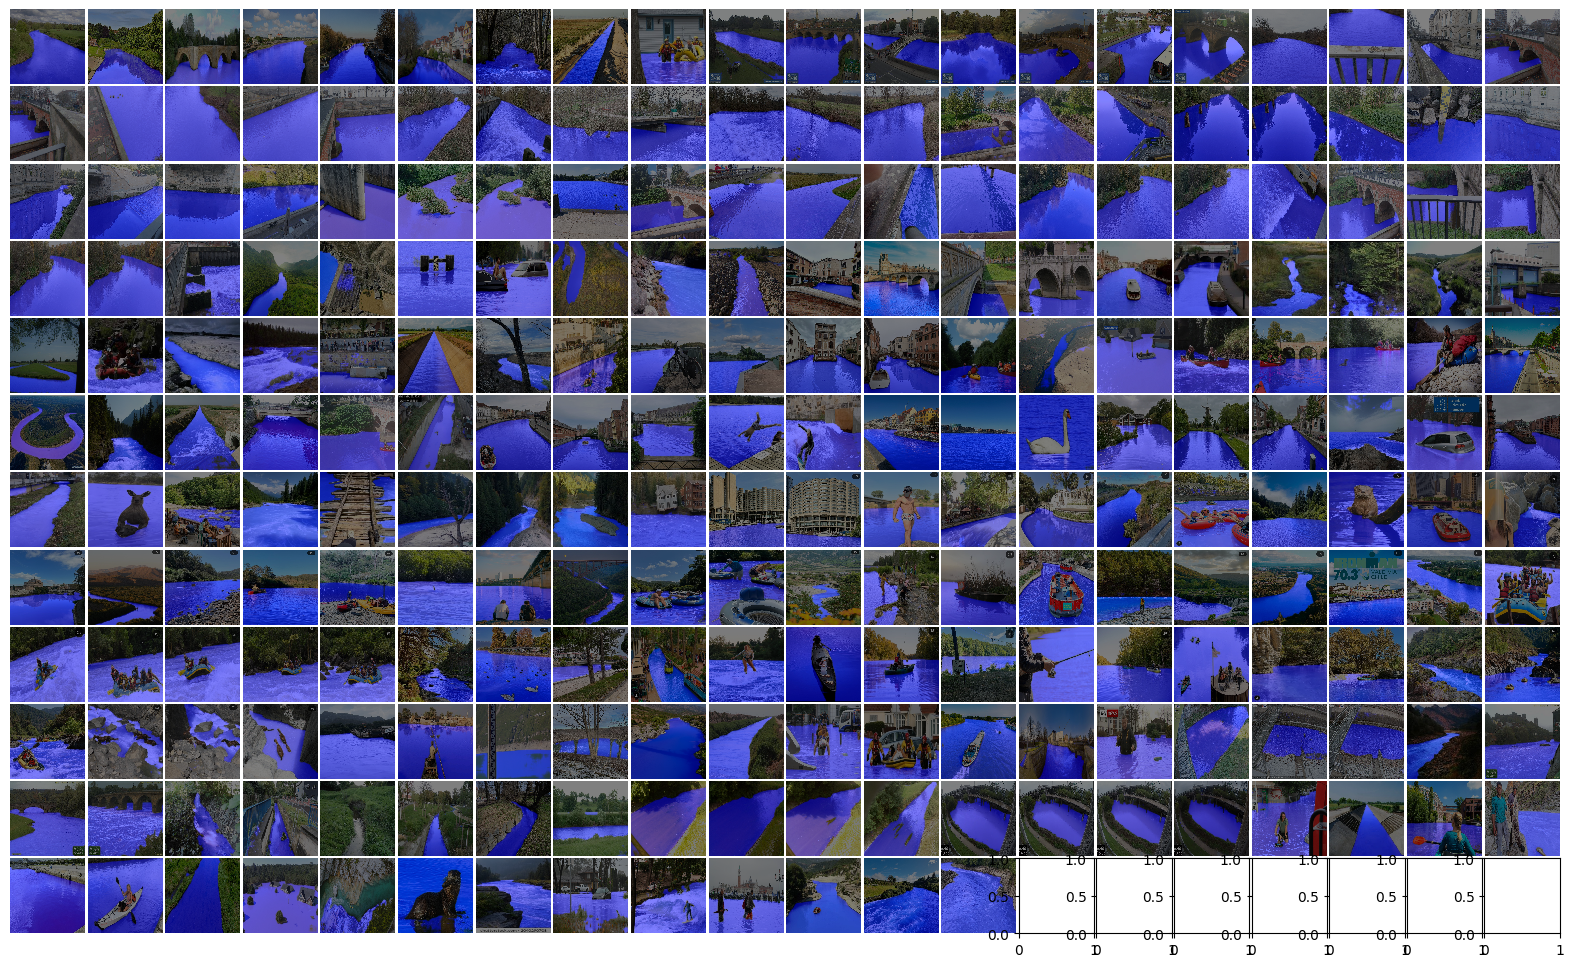

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming images_tuned_list and masks_binary_list are lists of RGB images and binary masks, respectively

# Create a 12x20 subplot grid
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

# Iterate over rows and columns
for i in range(12):
    for j in range(20):
        # Calculate the index for images_tuned_list and masks_binary_list
        index = i * 20 + j

        # Check if index is within the range of your data
        if index < len(images_tuned_list):
            # Display the RGB image
            axs[i, j].imshow(images_tuned_list[index], interpolation='none')

            # Create a blue mask with alpha channel
            blue_mask = np.zeros_like(masks_tuned_list[index])
            blue_mask[masks_tuned_list[index] == 1] = 1
            blue_mask_rgb = np.stack([np.zeros_like(blue_mask), np.zeros_like(blue_mask), blue_mask], axis=-1)
            # Overlay the blue mask on the RGB image
            axs[i, j].imshow(blue_mask_rgb, alpha=0.50)


            axs[i, j].axis('off')

# Reduce spacing between images
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# Adjust layout to prevent clipping of subplot labels
#plt.tight_layout()
#output_path = '/content/output_figure1200mobilsam.png'
#plt.savefig(output_path, dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import auc, roc_curve

def binary_segmentation_metrics(predictions, targets):
    # Convert torch tensors to numpy arrays
    # Convert torch tensors to numpy arrays
    predictions = predictions.squeeze()
    targets = targets
    # Convert predictions to binary values (0 or 1)
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.astype(int)

    # Convert predictions to binary values (0 or 1)
    predictions_binary = (predictions > 0.5).astype(int)

    # True Positives (TP): prediction and target both are positive
    TP = np.sum((predictions_binary == 1) & (targets == 1))

    # False Positives (FP): prediction is positive but target is negative
    FP = np.sum((predictions_binary == 1) & (targets == 0))

    # False Negatives (FN): prediction is negative but target is positive
    FN = np.sum((predictions_binary == 0) & (targets == 1))

    # True Negatives (TN): prediction and target both are negative
    TN = np.sum((predictions_binary == 0) & (targets == 0))

    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def calculate_average_metrics(predictions_list, targets_list):
    num_masks = len(predictions_list)

    total_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f_score': 0.0,
        'iou': 0.0,
        'kappa': 0.0,
        'FP': 0,
        'FN': 0,
        'MAR': 0.0,
        'FAR': 0.0,
        'dice': 0.0
    }

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        for metric_name, value in zip(total_metrics.keys(), metrics):
            total_metrics[metric_name] += value

        total_metrics['MAR'] += metrics[8] / (metrics[8] + metrics[9])
        total_metrics['FAR'] += metrics[6] / (metrics[9] + metrics[6])

    avg_metrics = {k: v / num_masks for k, v in total_metrics.items()}

    return avg_metrics

# Example usage

avg_metrics = calculate_average_metrics(masks_tuned_list, ground_truth_test_masks)

for metric_name, value in avg_metrics.items():
    print(f"Average {metric_name}: {value}")

Average accuracy: 0.9790510251294706
Average precision: 0.9719922937215263
Average recall: 0.9483410272248848
Average f_score: 0.9583727917616136
Average iou: 0.9313679421155749
Average kappa: 0.9401312791415248
Average FP: 1494.1545064377683
Average FN: 3997.49356223176
Average MAR: 100429.30822783643
Average FAR: 156223.4425083867
Average dice: 0.9583727917563114


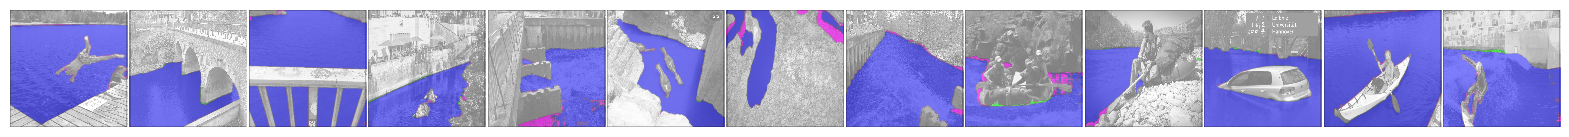

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.color import rgb2gray
from skimage.measure import find_contours

# Assuming images_tuned_list and masks_binary_list are lists of RGB images and binary masks, respectively
# Border parameters
border_color = 'black'
border_width = 0.35

# Create a 13x1 subplot grid for 13 images
fig, axs = plt.subplots(1, 13, figsize=(20, 10))

# Flatten the subplot grid for easy iteration
axs = axs.flatten()

# Select 13 images to display
selected_indices = [109, 57, 17, 87, 62, 183, 67, 26, 81, 98, 118, 221, 110]
# Iterate over selected indices
for i, index in enumerate(selected_indices):
    # Check if index is within the range of your data
    if index < len(images_tuned_list):
        # Display the RGB image
        gray_image = rgb2gray(images_tuned_list[index])

        axs[i].imshow(gray_image, cmap='gray', interpolation='none', alpha=0.5)  # Adjust alpha value as needed

        # Create a mask with alpha channel for segmentation result
        ground_truth_mask = (ground_truth_test_masks[index])
        mask = (masks_tuned_list[index])

        # Create a blue mask with alpha channel for true positives
        true_positive_mask = (mask == 1) & (ground_truth_mask == 1)
        blue_mask = np.stack([np.zeros_like(true_positive_mask), np.zeros_like(true_positive_mask), true_positive_mask], axis=-1)
        blue_mask_rgba = np.concatenate([blue_mask, true_positive_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(blue_mask_rgba, alpha=0.50)

        # Create a yellow mask with alpha channel for false alarms
        false_alarm_mask = (mask == 1) & (ground_truth_mask == 0)
        tight_green_mask = np.stack([np.zeros_like(false_alarm_mask), false_alarm_mask, np.zeros_like(false_alarm_mask)], axis=-1)
        tight_green_mask_rgba = np.concatenate([tight_green_mask, false_alarm_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(tight_green_mask_rgba, alpha=0.60)

        # Create a red mask with alpha channel for missed alarms
        missed_alarm_mask = (mask == 0) & (ground_truth_mask == 1)
        magenta_mask = np.stack([missed_alarm_mask, np.zeros_like(missed_alarm_mask), missed_alarm_mask], axis=-1)
        magenta_mask_rgba = np.concatenate([magenta_mask, missed_alarm_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(magenta_mask_rgba, alpha=0.60)

        # Add a black border around the image
        rect = Rectangle((0, 0), gray_image.shape[1], gray_image.shape[0], linewidth=border_width, edgecolor=border_color, facecolor='none')
        axs[i].add_patch(rect)

        # Turn off axis labels for better visualization
        axs[i].axis('off')

# Adjust layout to prevent clipping of subplot labels
plt.subplots_adjust(wspace=0.02, hspace=0.02)
# Adjust layout to prevent clipping of subplot labels
# Save the figure with 600 DPI
plt.subplots_adjust(wspace=0.02, hspace=0.02)

output_path = '/content/ViTSAML.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

Validation

In [ ]:
import numpy as np

def binary_segmentation_metrics(predictions, targets):
    # Convert torch tensors to numpy arrays
    predictions = predictions.squeeze()
    targets = targets
    # Convert predictions to binary values (0 or 1)
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.astype(int)

    # True Positives (TP): prediction and target both are positive
    TP = np.sum((predictions_binary == 1) & (targets == 1))

    # False Positives (FP): prediction is positive but target is negative
    FP = np.sum((predictions_binary == 1) & (targets == 0))

    # False Negatives (FN): prediction is negative but target is positive
    FN = np.sum((predictions_binary == 0) & (targets == 1))

    # True Negatives (TN): prediction and target both are negative
    TN = np.sum((predictions_binary == 0) & (targets == 0))

    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def categorize_metric(metric_value, metric_name):
    if metric_name == 'IoU':
        if metric_value > 0.90:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.90:
            return "Good"
        elif 0.75 <= metric_value < 0.85:
            return "Fair"
        elif 0.65 <= metric_value < 0.75:
            return "Poor"
        else:
            return "Unacceptable"
    elif metric_name == 'Precision':
        if metric_value > 0.95:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.95:
            return "Good"
        elif 0.65 <= metric_value < 0.85:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Kappa':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'F-Score':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Recall':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    else:
        return "Unknown"

def calculate_metrics_for_images(predictions_list, targets_list):
    num_masks = len(predictions_list)

    all_metrics = []

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        metrics_dict = {
            'Accuracy': metrics[0],
            'Precision': metrics[1],
            'Recall': metrics[2],
            'F-Score': metrics[3],
            'IoU': metrics[4],
            'Kappa': metrics[5],
            'FP': metrics[6],
            'FN': metrics[7],
            'TP': metrics[8],
            'TN': metrics[9],
            'Dice': metrics[10],
        }

        categorized_metrics = {}
        for metric_name, value in metrics_dict.items():
            category = categorize_metric(value, metric_name)
            categorized_metrics[metric_name + '_Category'] = category

        all_metrics.append({**metrics_dict, **categorized_metrics})

    return all_metrics

# Example usage

metrics_list = calculate_metrics_for_images(masks_tuned_list, ground_truth_test_masks)

# Initialize counters for each category
excellent_count_iou = 0
good_count_iou = 0
moderate_count_iou = 0
poor_count_iou = 0
fail_count_iou = 0

excellent_count_precision = 0
good_count_precision = 0
moderate_count_precision = 0
fail_count_precision = 0

excellent_count_kappa = 0
good_count_kappa = 0
moderate_count_kappa = 0
fail_count_kappa = 0

excellent_count_fscore = 0
good_count_fscore = 0
moderate_count_fscore = 0
fail_count_fscore = 0

excellent_count_recall = 0
good_count_recall = 0
moderate_count_recall = 0
fail_count_recall = 0

for i, metrics in enumerate(metrics_list):
    for metric_name, value in metrics.items():
        # Count the category for each metric
        if metric_name.endswith('_Category'):
            category = value
            if metric_name.startswith('IoU'):
                if category == 'Excellent':
                    excellent_count_iou += 1
                elif category == 'Good':
                    good_count_iou += 1
                elif category == 'Fair':
                    moderate_count_iou += 1
                elif category == 'Poor':
                    poor_count_iou += 1
                elif category == 'Unacceptable':
                    fail_count_iou += 1
            elif metric_name.startswith('Precision'):
                if category == 'Excellent':
                    excellent_count_precision += 1
                elif category == 'Good':
                    good_count_precision += 1
                elif category == 'Moderate':
                    moderate_count_precision += 1
                elif category == 'Fail':
                    fail_count_precision += 1
            elif metric_name.startswith('Kappa'):
                if category == 'Excellent':
                    excellent_count_kappa += 1
                elif category == 'Good':
                    good_count_kappa += 1
                elif category == 'Moderate':
                    moderate_count_kappa += 1
                elif category == 'Fail':
                    fail_count_kappa += 1
            elif metric_name.startswith('F-Score'):
                if category == 'Excellent':
                    excellent_count_fscore += 1
                elif category == 'Good':
                    good_count_fscore += 1
                elif category == 'Moderate':
                    moderate_count_fscore += 1
                elif category == 'Fail':
                    fail_count_fscore += 1
            elif metric_name.startswith('Recall'):
                if category == 'Excellent':
                    excellent_count_recall += 1
                elif category == 'Good':
                    good_count_recall += 1
                elif category == 'Moderate':
                    moderate_count_recall += 1
                elif category == 'Fail':
                    fail_count_recall += 1

# Calculate percentages
total_images = len(metrics_list)

excellent_percentage_iou = (excellent_count_iou / total_images) * 100
good_percentage_iou = (good_count_iou / total_images) * 100
moderate_percentage_iou = (moderate_count_iou / total_images) * 100
poor_percentage_iou = (poor_count_iou / total_images) * 100
fail_percentage_iou = (fail_count_iou / total_images) * 100

excellent_percentage_precision = (excellent_count_precision / total_images) * 100
good_percentage_precision = (good_count_precision / total_images) * 100
moderate_percentage_precision = (moderate_count_precision / total_images) * 100
fail_percentage_precision = (fail_count_precision / total_images) * 100

excellent_percentage_kappa = (excellent_count_kappa / total_images) * 100
good_percentage_kappa = (good_count_kappa / total_images) * 100
moderate_percentage_kappa = (moderate_count_kappa / total_images) * 100
fail_percentage_kappa = (fail_count_kappa / total_images) * 100

excellent_percentage_fscore = (excellent_count_fscore / total_images) * 100
good_percentage_fscore = (good_count_fscore / total_images) * 100
moderate_percentage_fscore = (moderate_count_fscore / total_images) * 100
fail_percentage_fscore = (fail_count_fscore / total_images) * 100

excellent_percentage_recall = (excellent_count_recall / total_images) * 100
good_percentage_recall = (good_count_recall / total_images) * 100
moderate_percentage_recall = (moderate_count_recall / total_images) * 100
fail_percentage_recall = (fail_count_recall / total_images) * 100

# Print counts and percentages
print("Counts and Percentages of Images in Each Category for IoU:")
print(f"Excellent: {excellent_count_iou} ({excellent_percentage_iou}%)")
print(f"Good: {good_count_iou} ({good_percentage_iou}%)")
print(f"Moderate: {moderate_count_iou} ({moderate_percentage_iou}%)")
print(f"Poor: {poor_count_iou} ({poor_percentage_iou}%)")
print(f"Fail: {fail_count_iou} ({fail_percentage_iou}%)")
print()

print("Counts and Percentages of Images in Each Category for Precision:")
print(f"Excellent: {excellent_count_precision} ({excellent_percentage_precision}%)")
print(f"Good: {good_count_precision} ({good_percentage_precision}%)")
print(f"Moderate: {moderate_count_precision} ({moderate_percentage_precision}%)")
print(f"Fail: {fail_count_precision} ({fail_percentage_precision}%)")
print()

print("Counts and Percentages of Images in Each Category for Kappa:")
print(f"Excellent: {excellent_count_kappa} ({excellent_percentage_kappa}%)")
print(f"Good: {good_count_kappa} ({good_percentage_kappa}%)")
print(f"Moderate: {moderate_count_kappa} ({moderate_percentage_kappa}%)")
print(f"Fail: {fail_count_kappa} ({fail_percentage_kappa}%)")
print()

print("Counts and Percentages of Images in Each Category for F-Score:")
print(f"Excellent: {excellent_count_fscore} ({excellent_percentage_fscore}%)")
print(f"Good: {good_count_fscore} ({good_percentage_fscore}%)")
print(f"Moderate: {moderate_count_fscore} ({moderate_percentage_fscore}%)")
print(f"Fail: {fail_count_fscore} ({fail_percentage_fscore}%)")
print()

print("Counts and Percentages of Images in Each Category for Recall:")
print(f"Excellent: {excellent_count_recall} ({excellent_percentage_recall}%)")
print(f"Good: {good_count_recall} ({good_percentage_recall}%)")
print(f"Moderate: {moderate_count_recall} ({moderate_percentage_recall}%)")
print(f"Fail: {fail_count_recall} ({fail_percentage_recall}%)")
print()


Counts and Percentages of Images in Each Category for IoU:
Excellent: 192 (82.40343347639485%)
Good: 18 (7.725321888412018%)
Moderate: 13 (5.579399141630901%)
Poor: 3 (1.2875536480686696%)
Fail: 7 (3.004291845493562%)

Counts and Percentages of Images in Each Category for Precision:
Excellent: 207 (88.8412017167382%)
Good: 20 (8.583690987124463%)
Moderate: 4 (1.7167381974248928%)
Fail: 2 (0.8583690987124464%)

Counts and Percentages of Images in Each Category for Kappa:
Excellent: 212 (90.98712446351931%)
Good: 13 (5.579399141630901%)
Moderate: 3 (1.2875536480686696%)
Fail: 5 (2.1459227467811157%)

Counts and Percentages of Images in Each Category for F-Score:
Excellent: 222 (95.27896995708154%)
Good: 5 (2.1459227467811157%)
Moderate: 1 (0.4291845493562232%)
Fail: 5 (2.1459227467811157%)

Counts and Percentages of Images in Each Category for Recall:
Excellent: 211 (90.55793991416309%)
Good: 14 (6.008583690987124%)
Moderate: 2 (0.8583690987124464%)
Fail: 6 (2.575107296137339%)

